# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 17 de abril de 2022__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [1]:
RANDOM_STATE = 10

# Apartado 1: Clasificador de noticias

__Número de grupo: 5__

__Nombres de los estudiantes: Jorge Villacorta y Pablo Martinez__

## 1) Carga del conjunto de datos

El fichero `BBC News.csv` contiene noticias clasificadas en 5 categorías diferentes. 

Carga los datos en un dataframe teniendo en cuenta que la columna `ArticleId` es un identificador de la noticia y por lo tanto no debes usarlo para clasificar. 

Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías. Indica si debemos tenerlo en cuenta de alguna forma al analizar los modelos que construyamos.

Muestra un mensaje cualquiera y explica si lo habrías clasificado en la clase correcta tras leerlo.

Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. 

#### Cargamos los datos en un dataFrame

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('BBC News.csv')
df = pd.DataFrame(df, columns= ['Text','Category'])

df

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business
...,...,...
1485,double eviction from big brother model caprice...,entertainment
1486,dj double act revamp chart show dj duo jk and ...,entertainment
1487,weak dollar hits reuters revenues at media gro...,business
1488,apple ipod family expands market apple has exp...,tech


#### Muestra un mensaje cualquiera y explica si lo habrías clasificado en la clase correcta tras leerlo.

In [4]:
print(df.loc[[666]])

                                                  Text Category
666  nuclear body seeks new tech the computer syste...     tech


In [5]:
print(df.loc[[999]])

                                                  Text  Category
999  brewers  profits lose their fizz heineken and ...  business


In [6]:
print(df.loc[[333]])

                                                  Text       Category
333  eminem beats elvis to number one rapper eminem...  entertainment


Como podemos ver en las tres consultas aleatorias, los mensajes pertenecen a ctegorias diferentes entre sí, y si podemos distinguir palabras claves que nos den pie a categorizarlas en la clase a la que pertenecen, como por ejemplo las palabras "tech" y "computer" para asociar el texto a la categoria de tecnología, las palabras "profits" y "fizz" para asociar el texto a la categoria de negocios y las palabras "beats" y "rapper eminen" para asociar el  texto a la categoria de entretenimiento. 

Luego, se puede clasificar fácilmente los textos de manera genérica en la categoria a la que pertenecen.

#### Análisis de los datos en categorías

In [7]:
df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

<AxesSubplot:ylabel='Category'>

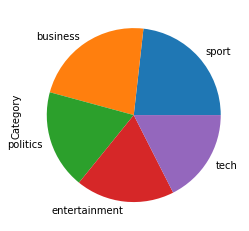

In [8]:
df['Category'].value_counts().plot.pie()

Como podemos observar en la gráficas, todas las categorias tiene mas o menos el mismo tamaño, lo cual nos permitira realizar una clasificación equilibrada, ya que hay mas o menos el mismo número de noticias de cada categoria (23% de las noticias pertenecen a la categoría "sport" y el 17,5% de las noticias pertenecen a "tech", habiendo una diferencia del 5,5% entre la categoría mas recurrente y la menos recurrente).

#### Creacción de las particiones

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
#80% para entrenamiento y el 20% restante para test
#X = df.loc[:, df.columns != 'Category'].copy()
#y = df['Category'].copy()

train_data, test_data = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

aux = {'Text': train_data.Text.tolist(),
       'Category': train_data.Category.tolist()}

train_data = pd.DataFrame(aux, columns= ['Text','Category'])

aux = {'Text': test_data.Text.tolist(),
       'Category': test_data.Category.tolist()}

test_data = pd.DataFrame(aux, columns= ['Text','Category'])


print(train_data)
print(test_data)

                                                   Text       Category
0     ferguson rues failure to cut gap boss sir alex...          sport
1     levy takes whitbread novel prize orange prize ...  entertainment
2     super size me wins writers  award super size m...  entertainment
3     irish finish with home game republic of irelan...          sport
4     irish markets reach all-time high irish shares...       business
...                                                 ...            ...
1187  ring of fire hit co-writer dies merle kilgore ...  entertainment
1188  gadget show heralds mp3 christmas partners of ...           tech
1189  navratilova hits out at critics martina navrat...          sport
1190  milburn defends poster campaign labour s elect...       politics
1191  eminem secret gig venue revealed rapper eminem...  entertainment

[1192 rows x 2 columns]
                                                  Text       Category
0    holmes feted with further honour double olympi..

## 2) Representación basada en bolsa de palabras y frecuencia de aparición

La primera vectorización que vamos a usar representará los mensajes usando el modelo de bolsa de palabras, monogramas y la frecuencia de aparición de cada palabra. Usa como _stop words_ las que vienen configuradas por defecto para el inglés.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test. Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

Entrena un clasificador Naive Bayes Multinomial y calcula su tasa de aciertos sobre el conjunto de entrenamiento y el conjunto de test. A continuación calcula los valores de precisión, exhaustividad y puntuación F1 para cada una de las clases. Dibuja la matriz de confusión. Analiza los resultados obtenidos.

A continuación, entrena un clasificador k-NN con la configuración por defecto y usando la misma vectorización. Analiza los resultados, ¿a qué crees que se deben?

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

### Vectorización de los conjuntos de entrenamiento y test

In [12]:
# Utilizamos como stop_words las que vienen configuradas por defecto para el inglés
vectorizer = CountVectorizer(stop_words='english', binary=False,ngram_range=(1,1))

train_vector_data=vectorizer.fit_transform(train_data['Text'])

print(train_vector_data[100])

  (0, 9036)	3
  (0, 12429)	3
  (0, 17410)	4
  (0, 20051)	1
  (0, 12435)	1
  (0, 11297)	2
  (0, 22069)	4
  (0, 2400)	1
  (0, 21941)	1
  (0, 1)	1
  (0, 11072)	1
  (0, 1845)	1
  (0, 2659)	1
  (0, 17932)	2
  (0, 4114)	1
  (0, 11188)	1
  (0, 10446)	1
  (0, 9563)	1
  (0, 16772)	1
  (0, 18734)	1
  (0, 1844)	1
  (0, 5809)	1
  (0, 1495)	1
  (0, 9831)	1
  (0, 94)	1
  :	:
  (0, 12894)	1
  (0, 18440)	1
  (0, 17705)	1
  (0, 11603)	1
  (0, 15569)	1
  (0, 5661)	1
  (0, 11604)	1
  (0, 5404)	1
  (0, 5128)	1
  (0, 21297)	1
  (0, 16440)	1
  (0, 445)	1
  (0, 18018)	1
  (0, 7474)	1
  (0, 1040)	1
  (0, 7132)	1
  (0, 4104)	1
  (0, 10102)	1
  (0, 14228)	1
  (0, 11417)	2
  (0, 18727)	1
  (0, 8848)	1
  (0, 14610)	1
  (0, 13422)	3
  (0, 2569)	1


In [13]:
## Extraemos las palabras de nuestro vector de palabras
feature_names = vectorizer.get_feature_names ()
print(len(feature_names))

22180


El vocabulario consta de mas de 22000 palabras

Echamos un vistazo a varias secciones del vocabulario para hacernos una idea de como son las palabras del mismo

In [14]:
#las 100 primeras palabras del vocabulario
print(feature_names[:100],'\n')
#100 palabras del medio del vocabulario
print(feature_names[11000:11100],'\n')
#las 100 últimas palabras del vocabulario
print(feature_names[-100:],'\n')

['00', '000', '0001', '000bn', '000m', '000th', '001', '001and', '001st', '0051', '007', '01', '0100', '0130', '028', '03', '04', '041', '04bn', '04secs', '05', '050', '050505', '0530', '0530gmt', '056', '05bn', '06', '060', '0630', '069', '07', '0700', '0710', '072', '0730', '08', '080', '0800', '0870', '088', '09', '0900', '093', '0950', '09bn', '09secs', '10', '100', '1000m', '1000th', '100bn', '100m', '100ml', '101', '102', '103', '104', '105', '105bn', '105m', '106', '106m', '107', '108', '10bn', '10ft', '10m', '10secs', '10th', '11', '110', '1100', '110m', '110th', '111', '111m', '112', '113', '1130', '1130p', '113bn', '115', '116', '116i', '117', '118', '119', '119bn', '119m', '11bn', '11m', '11pm', '11th', '12', '120', '1200', '1200m', '120gb', '120m'] 

['item', 'items', 'iterated', 'itf', 'itn', 'itpc', 'itrec', 'itunes', 'itv', 'itv1', 'itx', 'iv', 'ivan', 'ivankoe', 'ivanovic', 'iveta', 'ivo', 'ivory', 'iwata', 'ixis', 'iyad', 'jack', 'jackal', 'jackass', 'jacket', 'jackets

Utilizamos la siguiente función para ver los términos de los mensajes vectorizados y compararlos con los mensajes originales

In [15]:
import numpy as np
import numpy.ma as ma

In [16]:
def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index],'\n')
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [17]:
write_terms(feature_names, train_data['Text'], train_vector_data, 333)

Mensaje 333 : britain boosted by holmes double athletics fans endured a year of mixed emotions in 2004 as stunning victories went hand-in-hand with disappointing defeats and more drugs scandals.  kelly holmes finally fulfilled her potential by storming to double gold on the track at the olympic games. holmes helped erase the gloom hanging over team gb after their biggest medal hope  paula radcliffe  dropped out of the marathon and then the 10 000m. britain s men s 4x100m relay team also did their bit by taking a shock gold. holmes had started the year in disappointing style  falling over in the final of 1500m at the world indoor championships where she was favourite. her olympic build-up was clouded by self doubt but that proved unfounded as she overhauled rival maria mutola to win the 800m - her first global title. just five days later  the 34-year-old made it double gold in the 1500m. it was the first time in 84 years a briton has achieved the olympic middle-distance double. while ho

In [18]:
write_terms(feature_names, train_data['Text'], train_vector_data, 100)

Mensaje 100 : more power to the people says hp the digital revolution is focused on letting people tell and share their own stories  according to carly fiorina  chief of technology giant hewlett packard.  the job of firms such as hp now  she said in a speech at the consumer electronics show (ces)  was to ensure digital and physical worlds fully converged. she said the goal for 2005 was to make people the centre of technology. ces showcases 50 000 new gadgets that will be hitting the shelves in 2005. the tech-fest  the largest of its kind in the world  runs from 6 to 9 january.  the digital revolution is about the democratisation of technology and the experiences it makes possible   she told delegates.  revolution has always been about giving power to the people.  she added:  the real story of the digital revolution is not just new products  but the millions of experiences made possible and stories that millions can tell.  part of giving people more control has been about the freeing up

#### ¿Qué palabras se han eliminado y por qué?

Vemos que al tener el vocabulario palabras númericas, observamos ruido en la vectorización. También podemos ver que se eliminan palabras relevantes por no pertenecer al vocabulario con el que estamos entrenando, como puede ser "honda" o "eminen" y también se eliminan las palabras cuya frecuencia de aparición es baja, como los años o nombres de paises. Se observa que los "stop_words" tampoco aparecen, como hemos indicado en la vecotrización previamente.

### Clasificador Naive Bayes Multinomial

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix

Ahora realizaremos lo mismo pero en vez de con las frecuencias las palabras, lo haremos con una bolsa de palabras con TF/IDF

In [20]:
# Calculamos el valor TF-IDF 
tfidfer = TfidfTransformer()
train_preprocessed = tfidfer.fit_transform(train_vector_data)

# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data=vectorizer.transform(test_data['Text'])
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed=tfidfer.transform(test_vector_data)

Ya tenemos los conjuntos de entrenamiento y test preparados para ejecutar el clasificador

In [21]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_preprocessed, train_data['Category'])

mnb_train_predictions = mnb_classifier.predict(train_preprocessed)
mnb_test_predictions = mnb_classifier.predict(test_preprocessed)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == train_data['Category']))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == test_data['Category']))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9941275167785235
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.9731543624161074


In [22]:
classifier = mnb_classifier
predictions = mnb_test_predictions
names =["business","tech","politics","sport","entertainment"]

print(classification_report(test_data['Category'], predictions, target_names=names))

               precision    recall  f1-score   support

     business       0.97      1.00      0.98        56
         tech       0.98      0.95      0.97        62
     politics       0.93      1.00      0.96        52
        sport       0.99      1.00      0.99        80
entertainment       1.00      0.90      0.95        48

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



Observamos que para todas las categorias tiene una precisión muy elevada, y el porcentaje de clasificación para cada categoria es superior al 90% en todos los tipos de clases.

Podemos suponer que de forma general, el clasificador distingue bien los diferentes tipos de textos y los clasifica de forma genérica de forma correcta.

#### Matriz de confusión

In [23]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'tech'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'sport'),
  Text(4.5, 0, 'entertainment')])

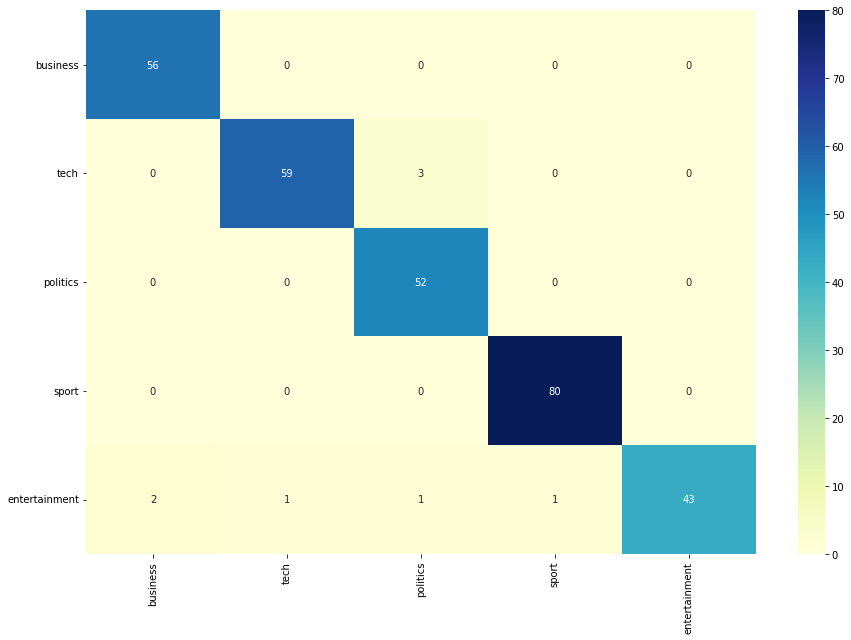

In [24]:
conf_matrix = confusion_matrix(test_data['Category'], predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=names, columns=names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Como podemos observar en la matriz de confusión, y de manera que corroboramos los datos de precisión y exhaustividad que hemos obtenido en el apartado anterior, el clasificador acierta casi en su totalidad a la hora de catalogar el texto. Donde vemos un mayor número de fallos, pero insignificante en comparación con el cómputo global, es a la hora de clasificar textos de tecnología y política (3 fallos de clasificación), y en los textos de negocios y entretenimiento (2 fallos de clasificación). También podemos obervar, que de forma general los textos pueden dar algun fallo en relación a la categoria de entretenimiento, pudiendo decir que es una categoria un poco más ambigua que el resto.

### Clasificador k-NN

In [25]:
from sklearn import neighbors

In [26]:
#usamos la distancia euclídea (por defecto)
knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_preprocessed, train_data['Category'])

knn_train_predictions = knn_classifier.predict(train_preprocessed)
knn_test_predictions = knn_classifier.predict(test_preprocessed)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == train_data['Category']))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == test_data['Category']))

k-NN, porcentaje de aciertos en entrenamiento: 0.9563758389261745
k-NN, porcentaje de aciertos en test: 0.9194630872483222


Observamos una tasa de aciertos muy elevada, parecida a los datos obtenidos en el anterior clasificador, por lo que podemos suponer que para este ejemplo de entrenamiento, se ha escogido valores justos de entrenamiento y test, y un vocabulario adecuado para valorar la aparición de las palabras en cada texto.

Este valor tan positivo puede ser debido a que el corpus no esta formado por excesivas palabras y no hay demasiadas clasificaciones como para que un texto sea ambiguo entre ambos, existe gran diferenciación entre clasificaciones de texto.

## 3) Representación basada en word-embeddings

La segunda vectorización que vamos a usar representará los mensajes usando word-embeddings. Cada documento se representará como el vector que resulta de promediar los embeddings de cada una de sus palabras. Al igual que en el apartado anterior, usaremos monogramas y las _stop words_ que vienen configuradas por defecto para el inglés. Recuerda usar como vocabulario para vectorizar el vocabulario del fichero con las word-embeddings. 

Entrena un clasificador Naive Bayes Gaussiano (el Multinomial no admite valores negativos que sí aparecen en los embeddings). Analiza el error por clase y dibuja la matriz de confusión.

Entrena otro clasificador kNN con la nueva vectorización y la configuración por defecto y analiza su error.

### Vectorización usando word-embeddings

Previamente, deberemos instalar el modulo gensim desde la consola Anaconda, ya que por defecto no viene instalado. Tendremos que escribir la siguiente linea: "pip install -U gensim"

In [27]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

Es necesario traducir el fichero al formato word2vec, que reconoce Gensim

In [28]:
glove_file = 'glove.6B.50d.txt'

# Gensim 4 puede transformar de glove a word2vec directamente
model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)


In [29]:
# En Gensim 3 se pueden obtener de la siguiente manera
# words = list(model.vocab.keys())

# En Gensim 4 se pueden obtener de la siguiente manera
# we_vocabulary = sorted(model.key_to_index.keys(), key=lambda word: model.get_vecattr(word, "count"), reverse=True)
we_vocabulary = list(model.key_to_index.keys())

# En vocabulary le pasamos el de la word-embedding, ponemos que pase los tokens a minusculas 
# Si ponemos binary a False coge frecuencias y si está en true presencia en modo binario
#vectorizer = CountVectorizer(vocabulary = we_vocabulary, binary = False)

# Si usamos la lista de palabras vacías del inglés de sklearn quitamos artículos, preposiciones, etc 
vectorizer = CountVectorizer(vocabulary = we_vocabulary, stop_words='english', binary = False)

train_vector_data = vectorizer.fit_transform(train_data['Text'])

In [30]:
feature_names = vectorizer.get_feature_names ()

In [31]:
write_terms(feature_names, train_data['Text'], train_vector_data, 333)

Mensaje 333 : britain boosted by holmes double athletics fans endured a year of mixed emotions in 2004 as stunning victories went hand-in-hand with disappointing defeats and more drugs scandals.  kelly holmes finally fulfilled her potential by storming to double gold on the track at the olympic games. holmes helped erase the gloom hanging over team gb after their biggest medal hope  paula radcliffe  dropped out of the marathon and then the 10 000m. britain s men s 4x100m relay team also did their bit by taking a shock gold. holmes had started the year in disappointing style  falling over in the final of 1500m at the world indoor championships where she was favourite. her olympic build-up was clouded by self doubt but that proved unfounded as she overhauled rival maria mutola to win the 800m - her first global title. just five days later  the 34-year-old made it double gold in the 1500m. it was the first time in 84 years a briton has achieved the olympic middle-distance double. while ho

### Clasificador Naive Bayes Gaussiano

In [32]:
from sklearn.naive_bayes import GaussianNB

In [33]:
# Calculamos el valor TF-IDF 
tfidfer = TfidfTransformer()
train_preprocessed = tfidfer.fit_transform(train_vector_data)

# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data=vectorizer.transform(test_data['Text'])
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed=tfidfer.transform(test_vector_data)

In [34]:
#usamos la opción de partial_fit que permite ajustar el Naive Bayes incrementalmente pasándole distintos fragmentos de la matriz de datos.
gnb_classifier = GaussianNB()

chunk_size=100
num_rows=len(test_data['Category'])

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_preprocessed[i*chunk_size : (i+1)*chunk_size,:].toarray()
    target_chunk = train_data['Category'][i*chunk_size : (i+1)*chunk_size]
    gnb_classifier.partial_fit(train_chunk, target_chunk, classes=np.unique(train_data['Category']))

In [35]:
# Creamos los arrays antes para ser más eficiente (crea el array grande y luego lo rellena)
gnb_train_predictions=np.zeros_like(train_data['Category'])
gnb_test_predictions=np.zeros_like(test_data['Category'])

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_preprocessed[i*chunk_size : (i+1)*chunk_size,:].toarray()
    gnb_train_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(train_chunk)
    
num_rows=len(test_data['Category'])
for i in range(0, (num_rows//chunk_size)):
    test_chunk = test_preprocessed[i*chunk_size : (i+1)*chunk_size,:].toarray()
    gnb_test_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(test_chunk)

print("Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(gnb_train_predictions == train_data['Category']))
print("Gaussian Naive Bayes, porcentaje de aciertos en test:", np.mean(gnb_test_predictions == test_data['Category']))

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento: 0.16778523489932887
Gaussian Naive Bayes, porcentaje de aciertos en test: 0.6073825503355704


Podemos observar que no clasifica muy bien para el conjunto de test, con un porcentaje del 60%, mientras que para el conjunto de entrenamiento tiene una tasa de acierto de 0.17, con lo cual podemos decir que el clasificador aprende muy despacio, se degrada mucho en entrenamiento.

In [44]:
gnb_test_predictions

array(['sport', 'sport', 'business', 'entertainment', 'entertainment',
       'tech', 'politics', 'sport', 'tech', 'politics', 'sport',
       'entertainment', 'business', 'entertainment', 'business', 'sport',
       'tech', 'business', 'business', 'entertainment', 'sport', 'sport',
       'entertainment', 'business', 'entertainment', 'tech',
       'entertainment', 'sport', 'politics', 'politics', 'sport', 'sport',
       'sport', 'entertainment', 'politics', 'politics', 'sport',
       'entertainment', 'tech', 'entertainment', 'sport', 'politics',
       'sport', 'entertainment', 'tech', 'tech', 'sport', 'sport',
       'sport', 'politics', 'sport', 'business', 'entertainment',
       'entertainment', 'sport', 'entertainment', 'entertainment',
       'entertainment', 'politics', 'sport', 'sport', 'tech', 'business',
       'sport', 'entertainment', 'politics', 'politics', 'sport',
       'entertainment', 'sport', 'entertainment', 'entertainment',
       'business', 'tech', 'politics'

Observamos que hay predicciones que no se llegan a producir. No sabemos si es por falta de datos o por nivel de cómputo de la maquina donde se esta  ejecutando o porque no admite valores negativos. Por ello añadimos una nueva categoria (categoria 0 para que se identifique en la predicciones), que indica lo explicado anteriormente.

In [47]:
#utilizamos astype porque la matriz contiene elementos de tipos diferentes
classifier = gnb_classifier
predictions = gnb_test_predictions.astype(str)
names =["business","tech","politics","sport","entertainment"]

print(classification_report(test_data['Category'], predictions, labels=names))

               precision    recall  f1-score   support

     business       0.94      0.52      0.67        56
         tech       0.77      0.56      0.65        48
     politics       0.90      0.67      0.77        52
        sport       0.96      0.64      0.77        80
entertainment       0.93      0.63      0.75        62

    micro avg       0.91      0.61      0.73       298
    macro avg       0.90      0.60      0.72       298
 weighted avg       0.91      0.61      0.73       298



El mal funcionamiento de este clasificador tiene que ver con que la distribución de los valores que tienen los términos en un documento no siguen una distribución normal. Para empezar no es simétrica, sino asimétrica a la derecha.

<AxesSubplot:ylabel='Density'>

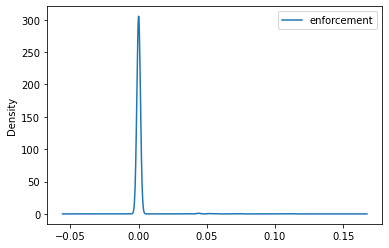

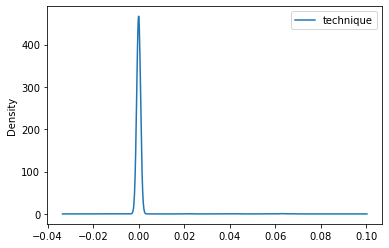

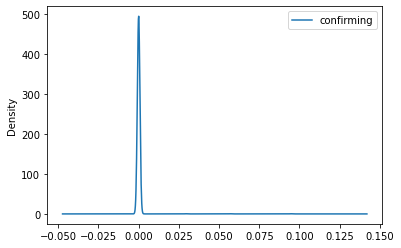

In [48]:
term=pd.DataFrame(data= train_preprocessed[:,2500].toarray(), columns=[feature_names[2500]])
term.plot.density()

term=pd.DataFrame(data= train_preprocessed[:,5000].toarray(), columns=[feature_names[5000]])
term.plot.density()

term=pd.DataFrame(data= train_preprocessed[:,11000].toarray(), columns=[feature_names[11000]])
term.plot.density()

#### Matriz de confusion

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'tech'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'sport'),
  Text(4.5, 0, 'entertainment'),
  Text(5.5, 0, '0')])

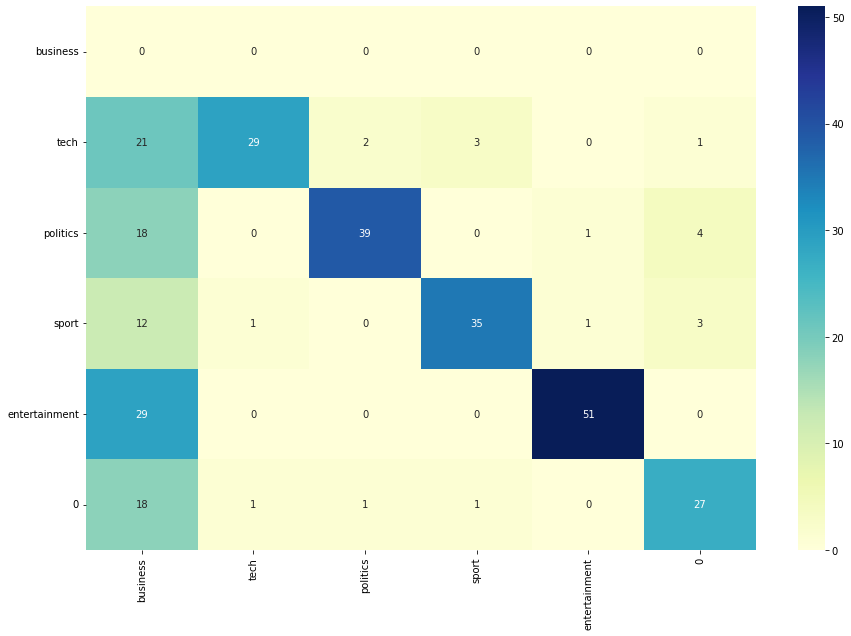

In [50]:
#Añadimos una columna extra que indica los textos que no se han llegado a clasificar
names =["business","tech","politics","sport","entertainment","0"]

conf_matrix = confusion_matrix(test_data['Category'], predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=names, columns=names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Observamos que para todos las clases de textos queestamos predcciendo, el clasificador falla mucho con respecto a la categoria de business. A demás, como hemos comentado antes, se dan casos en los que el clasificador no es capaz de asignar una clase al texto, cosa que con los anteriores clasificadores no ocurría.

### Clasificador kNN

In [62]:
#usamos la distancia euclídea (por defecto)
knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_preprocessed, train_data['Category'])

knn_train_predictions = knn_classifier.predict(train_preprocessed)
knn_test_predictions = knn_classifier.predict(test_preprocessed)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == train_data['Category']))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == test_data['Category']))

k-NN, porcentaje de aciertos en entrenamiento: 0.9563758389261745
k-NN, porcentaje de aciertos en test: 0.9194630872483222


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'tech'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'sport'),
  Text(4.5, 0, 'entertainment')])

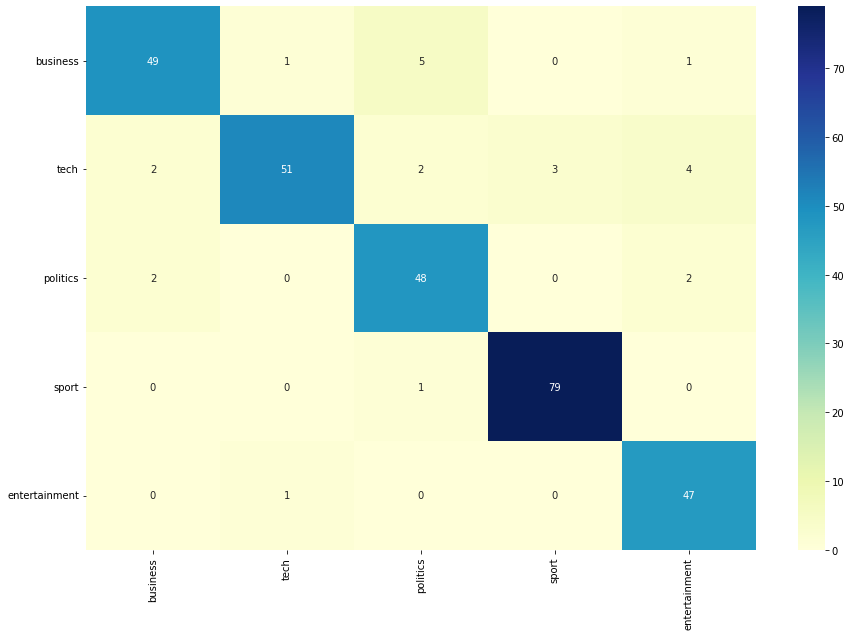

In [63]:
#Añadimos una columna extra que indica los textos que no se han llegado a clasificar
names =["business","tech","politics","sport","entertainment"]

conf_matrix = confusion_matrix(test_data['Category'], knn_test_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=names, columns=names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Podemos ver que para el modelo kNN, aprende bastante bien, teniendo porcentajes bastante similare de acierto, con lo cual podemos decir que el clasisificador esta aprendiendo de forma correcta.

La matriz de confusión nos desglosa los fallos del clasificador, y vemos que donde más fallos se producen son entre las clases politics y business, con un total de 5 fallos sobre 102 casos.

## 4) Análisis comparativo final

Hemos entrenado dos clasificadores usando dos vectorizaciones diferentes de los datos. Compara la tasa de acierto de todos ellos y explica a qué crees que se deben las diferencias.

Busca un mensaje mal clasificado por el Naive Bayes con vectorización de frecuencias y otro mal clasificado por el k-NN con Word-embeddings. Analiza los vectores de términos de dichos mensajes e intenta razonar por qué ha sido clasificado erróneamente.

Para el Naive Bayes con vectorización de frecuencias, elige dos clases donde el clasificador no haya funcionado bien y analiza las palabras más relevantes para clasificar una noticia como de dichas clases. Razona si lo que ves crees que influye en la posible confusión a la hora de clasificar entre dichas clases.

#### Comparativa de tasas de acierto

Vectorización usando el modelo de bolsa de palabras

    Clasificador Naive Bayes Multinomial
        porcentaje de aciertos en entrenamiento: 0.9941275167785235
        porcentaje de aciertos en test: 0.9731543624161074

    Clasificador k-NN
        porcentaje de aciertos en entrenamiento: 0.9563758389261745
        porcentaje de aciertos en test: 0.9194630872483222
        
Vectorización usando word-embeddings

    Clasificador Naive Bayes Gaussiano
        porcentaje de aciertos en entrenamiento: 0.16778523489932887
        porcentaje de aciertos en test: 0.6073825503355704
        
    Clasificador kNN
        porcentaje de aciertos en entrenamiento: 0.9563758389261745
        porcentaje de aciertos en test: 0.9228187919463087

Como podemos observar, salvo el clasificador Gaussiano con vectorización usando word-embeddings cuyas tasas de aciertos son muy inferiores al resto, los demás clasificadores alcanzan una tasa de aciertos, tanto en test como en entrenamiento, similar y muy elevada entre ellos.

Para el clasificador Naive Bayes Gaussiano, y como hemos visto antes, el mal funcionamiento tiene que ver con que la distribución de los valores que tienen los términos en un documento no siguen una distribución normal

En los clasificadores Naive Bayes, las variables predictoras son independientes entre sí, echo que puede afectar negativamente en la clasificación de textos de este ejercicio. A demás, estos algorítmos asignan una probabilidad de cero cuando en el conjunto de datos se tiene una característica no observada, lo que puede hacer que no sean tan eficaces para ciertos casos o incluso como hemos visto, que no sean capaces de determinar una clasificación.
Sin embargo, tienen en cuenta desde las variables más frecuentes hasta las que no llegan a aparecer y al proporcionarle bigramas o el valor TF/IDF de una bolsa de palabras con respecto a su corpus, permiten ponderar mejor al clasificador la relevancia de las variables dentro de cada clase. 

Por otro lado, y en comparación con el clasificador Naive Bayes, el clasificador KNN es más simple pero más seguro, dado que siempre asocia una solución de predicción en funcion del valor K que determinemos, aunque no sea óptima. Sin embargo, está muy ligado al almacenamiento de los datos de entrenamiento para dar una predicción, lo que computacionalmente es contraproducente pero no afecta a la efectividad de la predicción del mismo.

#### Mensaje mal clasificado por el Naive Bayes con vectorización de frecuencias

Para este caso, observando la matriz de confusión y la tasa de aciertos, vemos que apenas hay errores en la clasificación y los más frecuentes se producen entre las clases politics y tech, donde el clasificador falla 3 veces de un total de 111.

In [53]:
vectorizer = CountVectorizer(stop_words='english', binary=False,ngram_range=(1,1))
train_vector_data=vectorizer.fit_transform(train_data['Text'])

# Calculamos el valor TF-IDF 
tfidfer = TfidfTransformer()
train_preprocessed = tfidfer.fit_transform(train_vector_data)

# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data=vectorizer.transform(test_data['Text'])
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed=tfidfer.transform(test_vector_data)
mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_preprocessed, train_data['Category'])

mnb_train_predictions = mnb_classifier.predict(train_preprocessed)
mnb_test_predictions = mnb_classifier.predict(test_preprocessed)


In [55]:
def print_top25_features_per_class_in_NB(vectorizerF2, clf, target_names):
    """Prints features with the highest coefficient values, per class"""
    feature_namesF2 = vectorizerF2.get_feature_names()
    print("Top 25 features per class\n")
    for i, target_names in enumerate(target_names):
        top25 = np.argsort(clf.feature_log_prob_[i])[-25:]
        reversed_top = top25[::-1]
        
        print("%s: %s" % (target_names,
              " / ".join(feature_namesF2[j] for j in reversed_top)),'\n')
        
        #Descomentar para ver el índice de los términos en el diccionario
        #print("%s " % (" / ".join(str(j) for j in reversed_top)),'\n')

In [58]:
names=["business","tech","politics","sport","entertainment"]
print_top25_features_per_class_in_NB(vectorizer,mnb_classifier,names) 

Top 25 features per class

business: said / growth / market / year / economy / bank / firm / company / economic / oil / mr / sales / dollar / shares / 2004 / china / prices / government / new / india / profits / yukos / rates / deal / analysts 

tech: film / best / music / band / said / awards / award / album / actor / chart / star / year / number / tv / films / oscar / festival / singer / won / comedy / new / actress / director / uk / song 

politics: mr / labour / said / blair / election / party / government / brown / minister / howard / prime / tax / people / plans / tory / chancellor / tories / lord / secretary / lib / leader / uk / britain / eu / campaign 

sport: england / game / win / said / chelsea / cup / match / players / ireland / team / final / season / play / club / world / wales / time / half / injury / year / france / coach / rugby / arsenal / champion 

entertainment: people / mobile / said / software / technology / users / digital / net / phone / broadband / music / mi

Vemos cuales son las palabras más frecuentes para cada clase, dado que para encontrar un mensaje mal clasificado por este clasificador, deberiamos de buscar 3 de los 114 mensajes donde se encuentran los mal clasificados.

Vemos que las clases politics y tech, las cuales hemos visto en la matriz de confusión que son las clases donde el clasificador comete más fallos, comparten palabras como "said" y "uk", por lo que, viendo el numero de casos donde falla el casificador, podemos suponer que un motivo de sea la compartición de palabras.

#### Mensaje mal clasificado por el k-NN con Word-embeddings

Para este caso, observando la matriz de confusión y la tasa de aciertos, vemos que apenas hay errores en la clasificación y los más frecuentes se producen entre las clases politics y business, donde el clasificador falla 5 veces de un total de 102.